#### Peer Review (optional)
В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы mystem, коллекция сохранена в формате vowpal wabbit. В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека BigARTM. В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в Release Notes). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать предыдущий релиз или новый релиз на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице Python API.

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns 
%matplotlib inline
sns.set_style('whitegrid', {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interacitivty = 'all'

##### Считывание данных
Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path = 'lectures.txt', data_format = 'vowpal_wabbit',
                                       target_folder = 'lectures_batches', batch_size=250)

##### Инициализация модели
Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [6]:
T = 30 
topic_names =['sbj' +str(i) for i in range(T-1)] + ['bcg']
#print(topic_names)
model = artm.ARTM(num_topics=T, topic_names=topic_names, num_processors=2, 
                  class_ids={'text':1, 'author':1}, reuse_theta=True, cache_theta=True)

num_processors (int) – how many threads will be used for model training, if not specified then number of threads will be detected by the lib

class_ids (dict) – list of class_ids and their weights to be used in model, key — class_id, value — weight, if not specified then all class_ids will be used

reuse_theta (bool) – reuse Theta from previous iteration or not

cache_theta (bool) – save or not the Theta matrix in model. Necessary if ARTM.get_theta() usage expects

In [7]:
np.random.seed(1)
dictionary = artm.Dictionary('dict')
dictionary.gather(batch_vectorizer.data_path)
model.initialize(dictionary=dictionary)

##### Добавление score
Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [8]:
model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod1', class_id='text', num_tokens=15))
#model.scores.add(artm.TopTokensScore(name='top_tokens_score_mod2', class_id='author', num_tokens=15))

Построение модели
Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать статью, раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [9]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, class_ids='text', dictionary='dict',
                                                      topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [10]:
model.num_document_passes=1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [11]:
topic_names_cleared=list(topic_names).remove('bcg')
model.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, class_ids='text', dictionary='dict',
                                                      topic_names=topic_names_cleared))

Выполните еще 15 проходов по коллекции.

In [12]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем
Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [13]:
tokens = model.score_tracker['top_tokens_score_mod1'].last_tokens
for topic_name in model.topic_names:
    print(topic_name + ': ')
    for word in tokens[topic_name]:
        print(word)
    print

sbj0: 
церковь
власть
средневековый
император
русь
святой
римский
папа
князь
сага
король
александр
византийский
вера
рим
sbj1: 
планета
земля
атмосфера
солнце
солнечный
белый
газ
образовываться
карлик
вокруг
вода
поверхность
спутник
орбита
океан
sbj2: 
система
трудность
поведение
частота
двигаться
точность
искусственный
движение
относительность
тест
час
самка
задание
переход
часы
sbj3: 
культура
понятие
культурный
восприятие
сознание
феномен
личность
воспринимать
ощущение
чувство
повседневный
переживание
детство
этика
индивид
sbj4: 
право
литература
искусство
литературный
юрист
писатель
должник
собственность
обязательство
владение
римский
произведение
исполнение
юридический
требование
sbj5: 
материал
структура
молекула
свойство
углерод
применение
поверхность
полимер
кристалл
металл
электронный
твердый
трехмерный
алмаз
углеродный
sbj6: 
книга
фильм
автор
кино
написать
документ
жанр
театр
тема
кинематограф
академия
герой
анекдот
екатерина
культовый
sbj7: 
смерть
ритуал
террор
правитель
г

In [14]:
authors = model.score_tracker['top_tokens_score_mod2'].last_tokens
for topic_name in model.topic_names:
    print(topic_name + ': '),
    for author in authors[topic_name]:    
        print(author),
    print

sbj0: 
Александр_Марей
Фёдор_Успенский
Татьяна_Бобровникова
Павел_Уваров
Алексей_Юдин
Игорь_Данилевский
Ольга_Вайнштейн
Елена_Уханова
Ольга_Брилева
Владимир_Петрухин
Елена_Браун
Григорий_Бондаренко
Раиса_Кирсанова
Екатерина_Болтунова
Ольга_Тогоева
sbj1: 
Сергей_Попов
Кирилл_Еськов
Дмитрий_Вибе
Дмитрий_Титов
Валерий_Сулейманов
Зоригто_Намсараев
Сергей_Наугольных
Александр_Марков
Роман_Рафиков
Александр_Слободкин
Наталья_Новикова
Елизавета_Ривкина
Сергей_Писарев
Дмитрий_Лось
Юлия_Краус
sbj2: 
Елена_Брызгалина
Владимир_Мележик
Александр_Поддьяков
Михаил_Пантелеев
Эмиль_Ахмедов
Виталий_Пальчиков
Даниэль_Сельва
Михаил_Фейгельман
Антон_Суворов
Василий_Климов
Алексей_Желтиков
Юджин_Ползик
Илья_Щуров
Владимир_Редько
Алексей_Котов
sbj3: 
Алексей_Руткевич
Сергей_Арутюнов
Пётр_Турчин
Владимир_Миронов
Татьяна_Смоктунович
Андрей_Лосев
Константин_Анохин
Кирилл_Разлогов
Павел_Степанцов
Дмитрий_Иванов
Александр_Кислов
Фёдор_Гиренок
Павел_Умрюхин
Светлана_Кузнецова
Андрей_Лукашов
sbj4: 
Дмитрий_Дождев


В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему

частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый

можно назвать "Физика элементарных частиц".

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [16]:
sbj_topic_labels = ['русь','планета','механизм','культура','литература',
                    'углерод','кинематограф','ритуал','химия','квантовая_физика',
                    'история','семья','медицина','история_востока','вселенная',
                    'компьютерная','раса','философ','словарь','французская_революция',
                    'город','медицина','социология','матрица','мифы', 
                    'лингвистика','ссср','мозг','сопромат']

topic_labels = sbj_topic_labels + [u'Фоновая тема']
sbj_topic_labels

['русь',
 'планета',
 'механизм',
 'культура',
 'литература',
 'углерод',
 'кинематограф',
 'ритуал',
 'химия',
 'квантовая_физика',
 'история',
 'семья',
 'медицина',
 'история_востока',
 'вселенная',
 'компьютерная',
 'раса',
 'философ',
 'словарь',
 'французская_революция',
 'город',
 'медицина',
 'социология',
 'матрица',
 'мифы',
 'лингвистика',
 'ссср',
 'мозг',
 'сопромат']

##### Анализ тем
Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [17]:
model.theta_columns_naming = 'title'
theta = model.get_theta()
print(f'Theta shape:{str(theta.shape)}')
phi_a = model.get_phi(class_ids='author')
print(f'Phi_a: {phi_a.shape}')

Theta shape:(30, 1728)
Phi_a: (539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

In [21]:
theta.iloc[:,:100]

,http://postnauka.ru/video/32900,http://postnauka.ru/video/32901,http://postnauka.ru/video/32906,http://postnauka.ru/video/32918,http://postnauka.ru/video/32921,http://postnauka.ru/video/32924,http://postnauka.ru/video/33189,http://postnauka.ru/video/3348,http://postnauka.ru/video/3349,http://postnauka.ru/video/3352,...,http://postnauka.ru/video/3509,http://postnauka.ru/video/3511,http://postnauka.ru/video/35150,http://postnauka.ru/video/35461,http://postnauka.ru/video/35464,http://postnauka.ru/video/3599,http://postnauka.ru/video/3601,http://postnauka.ru/video/3602,http://postnauka.ru/video/3603,http://postnauka.ru/video/3604
sbj0,0.000000e+00,0.000000e+00,4.821443e-03,1.986645e-08,0.000000e+00,0.000000e+00,1.374705e-08,4.049008e-01,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.448192e-02,0.000000
sbj1,0.000000e+00,1.660485e-13,0.000000e+00,0.000000e+00,0.000000e+00,6.578958e-03,2.960533e-11,0.000000e+00,4.895535e-02,4.761361e-03,...,0.000000,1.834525e-01,3.812017e-03,6.936970e-03,0.000000e+00,0.000000,2.032309e-02,0.000000e+00,0.000000e+00,0.130547
sbj2,0.000000e+00,4.224082e-15,5.581667e-03,0.000000e+00,1.260573e-03,1.214017e-12,0.000000e+00,0.000000e+00,4.802059e-03,3.608435e-03,...,0.000000,5.138315e-02,1.420010e-09,0.000000e+00,1.154009e-02,0.017521,1.886437e-02,1.484118e-01,0.000000e+00,0.000000
sbj3,1.710399e-02,0.000000e+00,9.427554e-03,0.000000e+00,4.624987e-02,0.000000e+00,1.018206e-10,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,3.797176e-03,5.258314e-15,1.760709e-13,0.064516,3.943824e-06,0.000000e+00,6.896549e-02,0.027457
sbj4,5.129044e-14,6.885052e-08,1.443714e-06,2.945559e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.647926e-12,0.000000e+00,...,0.022369,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
sbj5,9.441384e-03,5.522357e-11,0.000000e+00,4.585218e-08,4.837394e-09,2.192080e-02,4.126938e-03,0.000000e+00,3.349420e-06,1.908504e-02,...,0.000000,7.994560e-10,1.768973e-07,6.737894e-03,6.570860e-02,0.000000,3.910859e-12,0.000000e+00,0.000000e+00,0.000000
sbj6,1.575074e-03,0.000000e+00,9.977780e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.185518e-02,0.000000e+00,9.806741e-09,...,0.000000,0.000000e+00,0.000000e+00,7.801002e-11,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.950146e-07,0.000000
sbj7,0.000000e+00,0.000000e+00,1.514160e-04,0.000000e+00,0.000000e+00,0.000000e+00,1.431236e-06,0.000000e+00,0.000000e+00,0.000000e+00,...,0.088321,5.182064e-03,0.000000e+00,0.000000e+00,2.336990e-13,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
sbj8,6.633807e-14,3.620013e-12,1.429786e-14,4.625549e-02,4.851534e-03,4.940864e-07,4.743170e-09,0.000000e+00,1.834680e-03,1.074757e-01,...,0.000567,8.844317e-06,0.000000e+00,7.357382e-03,2.245153e-02,0.001202,5.155832e-11,0.000000e+00,0.000000e+00,0.000000
sbj9,3.848278e-04,1.103993e-02,0.000000e+00,0.000000e+00,7.033194e-03,1.782261e-02,2.778666e-01,6.906237e-04,9.224809e-02,3.210948e-02,...,0.000286,2.562575e-07,3.667096e-15,0.000000e+00,1.937688e-03,0.000000,3.635574e-02,0.000000e+00,0.000000e+00,0.000000


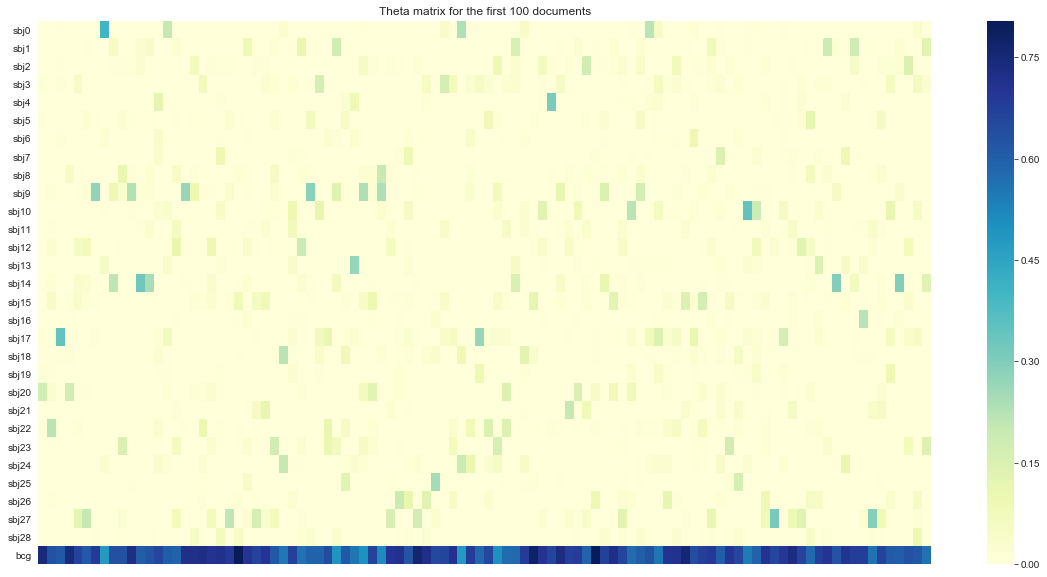

In [24]:
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
sns.heatmap(theta.iloc[:,:100], cmap='YlGnBu', xticklabels=False)
plt.show();